
#### Stroke Prediction Dataset
##### 11 clinical features for predicting stroke events

In [38]:
# importing the needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dython.nominal import associations

In [39]:
# import dataset
df = pd.read_csv("stroke-data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [40]:
df.shape

(5110, 12)

In [41]:
# check for null values
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

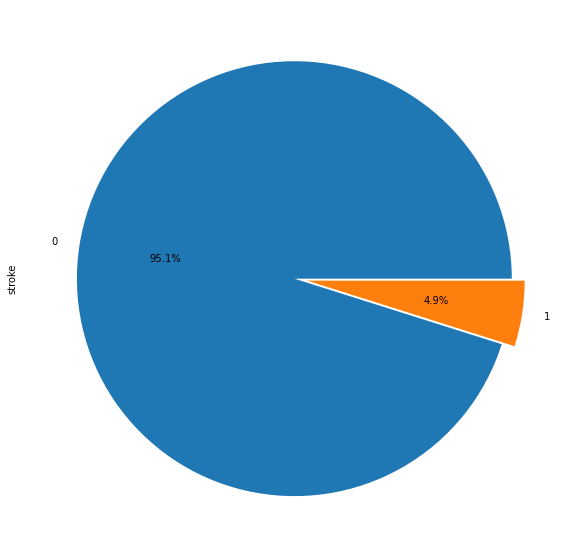

In [42]:
df.stroke.value_counts().plot(kind= "pie", autopct = "%.1f%%", figsize = (10,10), explode = (0.01,0.05));

In [43]:
df.age = df.age.astype("int")
df.bmi.fillna(df.bmi.mean(), inplace= True)

<AxesSubplot:>

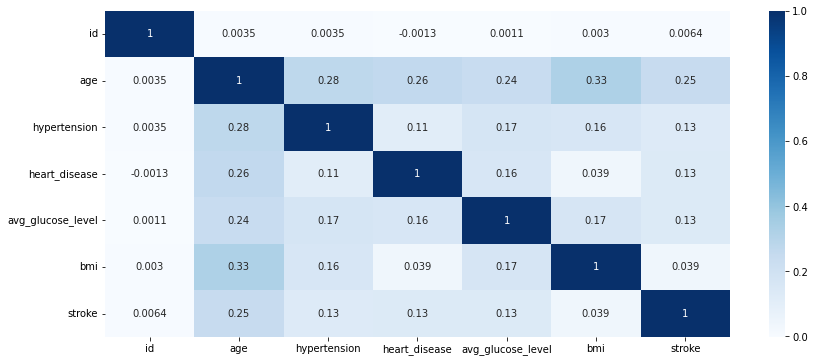

In [44]:
# feature correlation
fig,ax =plt.subplots(figsize = (14,6))
feature_check =sns.heatmap(df.corr(), cmap = "Blues", annot = True)
feature_check

## Preprocessing , change strings to numeric with OneHotEncoder

In [45]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df.gender =le.fit_transform(df.gender)
df.work_type =le.fit_transform(df.work_type)
df.Residence_type =le.fit_transform(df.Residence_type)
df.smoking_status =le.fit_transform(df.smoking_status)

df.sample()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1884,48739,1,47,0,0,Yes,3,1,135.19,36.0,3,0


In [57]:
# splitting the dataset into X an y
X = df.drop(["id","stroke","ever_married"], axis =1)
y = df.stroke
X.shape, y.shape
X

,gender,age,hypertension,heart_disease,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,1,67,0,1,2,1,228.69,36.600000,1
1,0,61,0,0,3,0,202.21,28.893237,2
2,1,80,0,1,2,0,105.92,32.500000,2
3,0,49,0,0,2,1,171.23,34.400000,3
4,0,79,1,0,3,0,174.12,24.000000,2
...,...,...,...,...,...,...,...,...,...
5105,0,80,1,0,2,1,83.75,28.893237,2
5106,0,81,0,0,3,1,125.20,40.000000,2
5107,0,35,0,0,3,0,82.99,30.600000,2
5108,1,51,0,0,2,0,166.29,25.600000,1


In [58]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=0)
X_res, y_res = sm.fit_resample(X, y)

In [59]:
from sklearn.model_selection import train_test_split , cross_val_score
X_train,X_test ,y_train ,y_test = train_test_split(X_res,y_res, test_size = 0.2, random_state = 0)  
X_train.shape ,X_test.shape  ,y_train.shape ,y_test.shape

((7777, 9), (1945, 9), (7777,), (1945,))

# Import needed estimators and libraries

In [60]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

 Training -Set Accuracy score is 79.30%
 Testing - Set Accuracy score is 81.13%



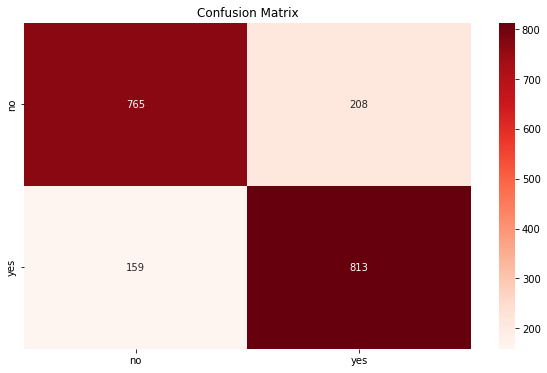

In [61]:
from sklearn.linear_model import LogisticRegression
lgr = LogisticRegression(solver='lbfgs', max_iter=1000, random_state = 42)
lgr.fit(X_train,y_train)
print(f' Training -Set Accuracy score is {lgr.score(X_train, y_train)*100:.2f}%')
print(f' Testing - Set Accuracy score is {lgr.score(X_test, y_test)*100:.2f}%')
y_pred1 = lgr.predict(X_test)
cm = confusion_matrix(y_test, y_pred1)

print()
fig,ax = plt.subplots(figsize = (10,6))
sns.heatmap(pd.DataFrame(cm, columns =['no',"yes"], \
    index = ["no", "yes"]),cmap = 'Reds',xticklabels = True, annot =True,fmt = "d", ax = ax)
ax.set(title ="Confusion Matrix");

 Training -Set Accuracy score is 100.00%
 Testing - Set Accuracy score is 93.88%


              precision    recall  f1-score   support

           0       0.96      0.92      0.94       973
           1       0.92      0.96      0.94       972

    accuracy                           0.94      1945
   macro avg       0.94      0.94      0.94      1945
weighted avg       0.94      0.94      0.94      1945



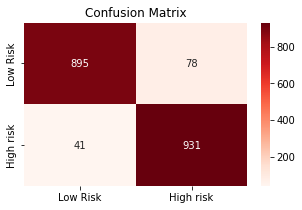

In [62]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators= 100, n_jobs = 1 , random_state = 42)
clf.fit(X_train,y_train)

print(f' Training -Set Accuracy score is {clf.score(X_train, y_train)*100:.2f}%')
print(f' Testing - Set Accuracy score is {clf.score(X_test, y_test)*100:.2f}%')

y_pred2 = clf.predict(X_test)
confusion_mx = confusion_matrix(y_test, y_pred2)

conf_max_df = pd.DataFrame(confusion_mx, index =["Low Risk", "High risk"], columns =["Low Risk", "High risk"])

print()
fig,ax = plt.subplots(figsize = (5,3))
sns.heatmap(conf_max_df,\
cmap = 'Reds',xticklabels = True, annot =True,fmt = "d", ax = ax)
ax.set(title ="Confusion Matrix");

print()
cr = classification_report(y_test, y_pred2)
print(cr)

In [63]:
conf_max_df.to_csv("conf_max_df.csv", index = False)


## Save the model

In [64]:
import pickle
pickle.dump(clf, open("estimator_pkl", "wb"))

In [65]:
import joblib
joblib.dump("clf","estimator_jolib")

['estimator_jolib']

In [66]:
clf.predict (ex)

array([1], dtype=int64)